# StarGAN CelebA

This notebook is for implementing `StarGAN` from the paper [StarGAN: Unified Generative Adversarial Networks for Multi-Domain Image-to-Image Translation](https://arxiv.org/abs/1711.09020) with [Tensorflow](https://www.tensorflow.org). <br>
[CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset), which is 128x128 size, will be used. 

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import cv2 
import datetime
import copy

## Parameters


In [3]:
algorithm = 'StarGAN_CelebA'

img_size   = 128

batch_size = 32
num_epoch  = 1

beta1 = 0
beta2 = 0.9

learning_rate_g = 0.0001
learning_rate_d = 0.0001

attribute_size = 8

show_result_step = 250

gpu_fraction = 0.9 

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190830-13-33-06_StarGAN_CelebA/model/model" 

# WGAN_GP Parateter
n_critic = 1
d_lambda = 10 

# StarGAN Parameter
lambda_cls = 20.0
lambda_rec = 4.0

## Import CelebA Dataset

Get names of the files in the celeba dataset folder.

In [4]:
celebA_list = glob.glob('/home/mmc-server2/dataset/celebA/img_align_celeba/*.jpg')
celebA_list.sort()
celebA_idx_list = np.arange(len(celebA_list))

print("CelebA dataset Length: {}".format(len(celebA_list)))

CelebA dataset Length: 202599


## Get CelebA Attribute

In [5]:
txt_file = open("list_attr_celeba.txt",'r')
contents = txt_file.readlines()
lines = [x.strip() for x in contents]

## Get Attribute Function

In [6]:
def Get_Attribute(idx):
    new_attr_idx_list = [8, 9, 11, 15, 18, 20, 31, 39]
    
    attribute_temp_str = lines[idx+2]
    attribute_temp_split = attribute_temp_str.split(' ')

    attribute_temp = np.zeros([1,img_size,img_size,attribute_size])
    attr_original = np.zeros([1, 40])
    
    count = 0
    for s in attribute_temp_split:  
        if s == '-1':
            attr_original[0,count] = 0
            count += 1

        if s == '1':
            attr_original[0,count] = 1
            count += 1
    
    for i in range(len(new_attr_idx_list)):
        if attr_original[0,new_attr_idx_list[i]] == 1:
            attribute_temp[:,:,:,i] = 1
        else:
            attribute_temp[:,:,:,i] = 0
    
    # Check the data has hat attribute
    if attr_original[0, 35] == 1 or attr_original[0,4] == 1:
        is_hat = True
    else:
        is_hat = False
    
    return attribute_temp, is_hat

## Check Attribute

0: 5_o_Clock_Shadow / 
1: Arched Eyerbrows / 
2: Attractive / 
3: Bags Under Eyes / 
4: Bald / 
5: Bangs / 
6: Big Lips / 
7: Big Nose / 
8: Black Hair / 
9: Blond Hair / 
10: Blurry / 
11: Brown Hair / 
12: Bushy Eyebrows / 
13: Chubby / 
14: Double Chin / 
15: Eyeglasses / 
16: Goatee / 
17: Gray Hair / 
18: Heavy Makeup / 
19: High Cheekbones / 
20: Male / 
21: Mouth Slightly Open / 
22: Mustache / 
23: Narrow Eyes / 
24: No Beard / 
25: Oval Face / 
26: Pale Skin / 
27: Pointy Nose / 
28: Receding Hairline / 
29: Rosy Cheeks / 
30: Sideburns / 
31: Smiling / 
32: Straight Hair / 
33: Wavy Hair / 
34: Wearing Earrings / 
35: Wearing Hat / 
36: Wearing Lipstic / 
37: Wearing Necklace / 
38: Wearing Necktie / 
39: Young

In [22]:
attr_list = ['5_o Clock Shadow', 'Arched Eyebrows', 'Attractive', 'Bags Under Eyes', 'Bald', 'Bangs', 'Big Lips', 'Big Nose',
             'Black Hair', 'Blond Hair', 'Blurry', 'Brown Hair', 'Bushy Eyebrows', 'Chubby', 'Double Chin', 'Eyeglasses', 'Goatee',
             'Gray Hair', 'Heavy Makeup', 'High Cheekbones', 'Male', 'Mouth Slightly Open', 'Mustache', 'Narrow Eyes', 'No beard',
             'Oval Face', 'Pale Skin', 'Pointy Nose', 'Receding Hairline', 'Rosy Cheeks', 'Sideburns', 'Smiling', 'Straight Hair',
             'Wavy Hair', 'Wearing Earrings', 'Wearing Hat', 'Wearing Lipstic', 'Wearing Necklace', 'Wearing Necktie', 'Young']

attr_list_new = ['Black Hair', 'Blond Hair', 'Brown Hair', 'Eyeglasses', 'Heavy Makeup', 'Male', 'Smiling', 'Young']

attr_name = ['Black Hair', 'Blond Hair', 'Brown Hair', 'Eyeglasses', 'Makeup', 'Male', 'Smiling', 'Young']
no_attr_name = ['', '', '', 'No Eyeglasses', 'No Makeup', 'Female', "No Smiling", 'Old']

change_attr_list = [3, 4, 5, 6, 7]
hair_attr_list = [0, 1, 2]

In [8]:
def Get_Target_Attribute(attr_):
    attr = copy.deepcopy(attr_)
    hair_attr_list_temp = copy.deepcopy(hair_attr_list)
      
    change_attr_idx = random.sample(change_attr_list, 1)[0]
    
    if attr[0, 0, 0, change_attr_idx] == 0:
        attr[0, :, :, change_attr_idx] = 1
    else:
        attr[0, :, :, change_attr_idx] = 0
   
    for i in hair_attr_list:
        if attr[0, 0, 0, i] == 1:
            attr[0, :, :, i] = 0
            hair_attr_list_temp.remove(i)
    
    hair_idx = random.sample(hair_attr_list_temp, 1)[0]
    attr[0, :, :, hair_idx] = 1
        
    return attr     

-------------Attribute-------------
Brown Hair
Male
Smiling
Young

Is hat: False
-------------Target Attribute Test-------------
Blond Hair
Smiling
Young


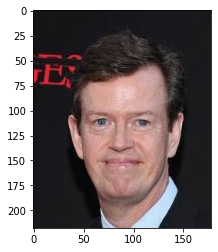

In [9]:
idx_sample = np.random.randint(len(celebA_list))
idx_temp = celebA_idx_list[idx_sample]
img_sample = cv2.imread(celebA_list[idx_temp])
img_sample_RGB = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

attribute_temp, is_hat = Get_Attribute(idx_sample)        
attribute_target_temp = Get_Target_Attribute(attribute_temp)

plt.imshow(img_sample_RGB)

print("-------------Attribute-------------")
for i in range(len(attribute_temp[0,0,0,:])):
    if attribute_temp[0,0,0,i] == 1:
        print(attr_list_new[i])
        
print("\nIs hat: {}".format(is_hat))
        
print('-------------Target Attribute Test-------------')
for i in range(len(attribute_target_temp[0,0,0,:])):
    if attribute_target_temp[0,0,0,i] == 1:
        print(attr_list_new[i])

## Generator

In [10]:
def ResNet(x, is_training, network_name):
        
    h = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, padding='SAME', name=network_name+'_1')
    h = tf.contrib.layers.instance_norm(h)
    h = tf.nn.relu(h)
    h = tf.layers.conv2d(h, filters=512, kernel_size=3, strides=1, padding='SAME', name=network_name+'_2')
    h = tf.contrib.layers.instance_norm(h)
    h = x + h 
    h = tf.nn.relu(h)
    
    return h

def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # First Conv (c7s1-32)
        e1 = tf.layers.conv2d(x, filters=64, kernel_size=7, strides=1, padding='SAME')
        e1 = tf.contrib.layers.instance_norm(e1)
        e1 = tf.nn.leaky_relu(e1)

        # Second Conv (d64)
        e2 = tf.layers.conv2d(e1, filters=128, kernel_size=3, strides=2, padding='SAME')
        e2 = tf.contrib.layers.instance_norm(e2)
        e2 = tf.nn.relu(e2)

        # Third Conv (d128)
        e3 = tf.layers.conv2d(e2, filters=256, kernel_size=3, strides=2, padding='SAME')
        e3 = tf.contrib.layers.instance_norm(e3)
        e3 = tf.nn.relu(e3)


        # Third Conv (d128)
        e4 = tf.layers.conv2d(e3, filters=256, kernel_size=3, strides=2, padding='SAME')
        e4 = tf.contrib.layers.instance_norm(e4)
        e4 = tf.nn.relu(e4)


        # Third Conv (d128)
        e5 = tf.layers.conv2d(e4, filters=256, kernel_size=3, strides=2, padding='SAME')
        e5 = tf.contrib.layers.instance_norm(e5)
        e5 = tf.nn.relu(e5)


        # Third Conv (d128)
        e6 = tf.layers.conv2d(e5, filters=512, kernel_size=3, strides=2, padding='SAME')
        e6 = tf.contrib.layers.instance_norm(e6)
        e6 = tf.nn.relu(e6)


        # Third Conv (d128)
        e7 = tf.layers.conv2d(e6, filters=512, kernel_size=3, strides=2, padding='SAME')
        e7 = tf.contrib.layers.instance_norm(e7)
        e7 = tf.nn.relu(e7)

        # Third Conv (d128)
        e8 = tf.layers.conv2d(e7, filters=512, kernel_size=3, strides=2, padding='SAME')
        e8 = tf.contrib.layers.instance_norm(e8)
        e8 = tf.nn.relu(e8)

        # ResNet Blocks (R128)
        r1 = ResNet(e8, is_training, 'resnet1')
        r2 = ResNet(r1, is_training, 'resnet2')
        r3 = ResNet(r2, is_training, 'resnet3')
        r4 = ResNet(r3, is_training, 'resnet4')
        r5 = ResNet(r4, is_training, 'resnet5')
        r6 = ResNet(r5, is_training, 'resnet6')
        r7 = ResNet(r6, is_training, 'resnet7')
        r8 = ResNet(r7, is_training, 'resnet8')
        r9 = ResNet(r8, is_training, 'resnet9')

        # FIrst Deconv Layer (u64)
        d1 = tf.layers.conv2d_transpose(r9,filters=512, kernel_size=3, strides=2, padding='SAME')
        d1 = tf.contrib.layers.instance_norm(d1)
        d1 = tf.nn.relu(d1)
        d1 = tf.concat([d1, e7], 3)

        d2 = tf.layers.conv2d_transpose(d1,filters=512, kernel_size=3, strides=2, padding='SAME')
        d2 = tf.contrib.layers.instance_norm(d2)
        d2 = tf.nn.relu(d2)
        d2 = tf.concat([d2, e6], 3)

        d3 = tf.layers.conv2d_transpose(d2,filters=512, kernel_size=3, strides=2, padding='SAME')
        d3 = tf.contrib.layers.instance_norm(d3)
        d3 = tf.nn.relu(d3)
        d3 = tf.concat([d3, e5], 3)

        d4 = tf.layers.conv2d_transpose(d3,filters=256, kernel_size=3, strides=2, padding='SAME')
        d4 = tf.contrib.layers.instance_norm(d4)
        d4 = tf.nn.relu(d4)
        d4 = tf.concat([d4, e4], 3)

        d5 = tf.layers.conv2d_transpose(d4,filters=256, kernel_size=3, strides=2, padding='SAME')
        d5 = tf.contrib.layers.instance_norm(d5)
        d5 = tf.nn.relu(d5)
        d5 = tf.concat([d5, e3], 3)

        d6 = tf.layers.conv2d_transpose(d5,filters=128, kernel_size=3, strides=2, padding='SAME')
        d6 = tf.contrib.layers.instance_norm(d6)
        d6 = tf.nn.relu(d6)
        d6 = tf.concat([d6, e2], 3)

        d7 = tf.layers.conv2d_transpose(d6,filters=64, kernel_size=3, strides=2, padding='SAME')
        d7 = tf.contrib.layers.instance_norm(d7)
        d7 = tf.nn.relu(d7)
        d7 = tf.concat([d7, e1], 3)

        # Last Conv (c7s1-3)       
        output = tf.tanh(tf.layers.conv2d(d7, filters=3, kernel_size=3, strides=1, padding='SAME')) 

        return output

## Discriminator

In [11]:
def Discriminator(x, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Hidden layer
        conv1 = tf.layers.conv2d(inputs=x,filters=64,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv2 = tf.layers.conv2d(inputs=conv1,filters=128,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv3 = tf.layers.conv2d(inputs=conv2,filters=256,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv4 = tf.layers.conv2d(inputs=conv3,filters=512,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv5 = tf.layers.conv2d(inputs=conv4,filters=1024,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv6 = tf.layers.conv2d(inputs=conv5,filters=2048,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")

        # Output layer
        out_src = tf.layers.conv2d(inputs=conv6,filters=1,activation=None,kernel_size=[2,2],strides=[2,2],padding="SAME")
        out_cls = tf.layers.conv2d(inputs=conv6,filters=attribute_size,activation=None,kernel_size=[2,2],strides=[2,2],padding="SAME")

        logit_src = tf.reshape(out_src, (-1, out_src.get_shape()[1]*out_src.get_shape()[2]*out_src.get_shape()[3]))
        logit_cls = tf.reshape(out_cls, (-1, out_cls.get_shape()[1]*out_cls.get_shape()[2]*out_cls.get_shape()[3]))

        return logit_src, logit_cls

## GAN

In [12]:
def GAN(x, attr_origin, attr_target, is_training):

    x_G_target = tf.concat([x, attr_target], 3)
    
    y_origin = tf.slice(attr_origin, [0, 0, 0, 0], [-1, 1, 1, -1])
    y_target = tf.slice(attr_target, [0, 0, 0, 0], [-1, 1, 1, -1])
    
    y_origin = tf.reshape(y_origin, (-1, attribute_size))
    y_target = tf.reshape(y_target, (-1, attribute_size))
    
    # Generator
    G = Generator(x_G_target, is_training)
    
    # Discriminator
    D_src_real, D_cls_real = Discriminator(x, is_training)
    D_src_fake, D_cls_fake = Discriminator(G, is_training, reuse=True)    

    # Domain Classification Loss 
    L_cls_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_origin, logits=D_cls_real))
    L_cls_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_target, logits=D_cls_fake))
    
    # Reconstruction Loss 
    x_G_origin = tf.concat([G, attr_origin], 3)
    
    G_r = Generator(x_G_origin, is_training, reuse=True)
    L_rec = tf.reduce_mean(tf.abs(G_r - x))
    
    # Adversarial Loss 
    ########################################### WGAN GP ###########################################
    eps = tf.random_uniform(shape=tf.shape(x),minval=0.0, maxval=1.0)
    x_hat = (eps * x) + ((1-eps) * G)
    D_hat, _ = Discriminator(x_hat, is_training, reuse=True)
    grad = tf.gradients(D_hat, [x_hat])[0]
    GP = d_lambda * tf.square(tf.norm(grad, ord=2) - 1)
    ###############################################################################################
    
    d_loss = -tf.reduce_mean(D_src_real) + tf.reduce_mean(D_src_fake) + GP + (lambda_cls * L_cls_real)
    g_loss = -tf.reduce_mean(D_src_fake) + (lambda_cls * L_cls_fake) + (lambda_rec * L_rec)
    
    cls_loss_real = lambda_cls * L_cls_real 
    cls_loss_fake = lambda_cls * L_cls_fake
    rec_loss = lambda_rec * L_rec
    
    return d_loss, g_loss , G, cls_loss_real, cls_loss_fake, rec_loss

## Build Graph

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

attr_origin = tf.placeholder(tf.float32, shape=[None, img_size, img_size, attribute_size])
attr_target   = tf.placeholder(tf.float32, shape=[None, img_size, img_size, attribute_size])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G, cls_loss_real, cls_loss_fake, rec_loss = GAN(x_normalize, attr_origin, attr_target, is_training) 

cls_loss = cls_loss_fake + cls_loss_real

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d, beta1, beta2).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g, beta1, beta2).minimize(g_loss, var_list=trainable_variables_g)
    train_step_cls = tf.train.AdamOptimizer(0.5*learning_rate_g, beta1, beta2).minimize(cls_loss_fake, var_list=trainable_variables_g)

## Initialization

In [14]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [15]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / Batch: 0.039% / G Loss: 8.59784 / D Loss: 3.65231 / CLS Loss real: 7.63760 / CLS Loss fake: 4.16547 / Rec Loss: 1.24203110
------------------------------Original Attribute------------------------------
Brown Hair
Heavy Makeup
Smiling
Young

------------------------------Target Attribute------------------------------
Black Hair
Heavy Makeup
Young


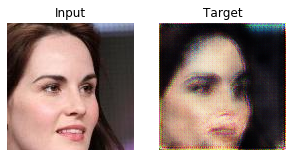

Epoch: 1 / Batch: 0.079% / G Loss: 6.60243 / D Loss: 1.68035 / CLS Loss real: 5.38658 / CLS Loss fake: 1.47099 / Rec Loss: 1.12218225
------------------------------Original Attribute------------------------------
Black Hair
Heavy Makeup
Smiling
Young

------------------------------Target Attribute------------------------------
Brown Hair
Heavy Makeup
Smiling


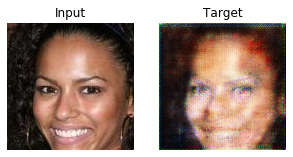

Epoch: 1 / Batch: 0.118% / G Loss: 4.06017 / D Loss: 2.88066 / CLS Loss real: 5.45970 / CLS Loss fake: 1.61937 / Rec Loss: 0.89818907
------------------------------Original Attribute------------------------------
Black Hair
Male
Young

------------------------------Target Attribute------------------------------
Brown Hair
Heavy Makeup
Male
Young


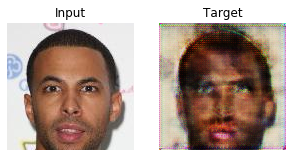

Epoch: 1 / Batch: 0.158% / G Loss: 2.86121 / D Loss: 2.47877 / CLS Loss real: 5.38382 / CLS Loss fake: 0.66787 / Rec Loss: 0.93651658
------------------------------Original Attribute------------------------------
Brown Hair
Male
Smiling
Young

------------------------------Target Attribute------------------------------
Blond Hair
Eyeglasses
Male
Smiling
Young


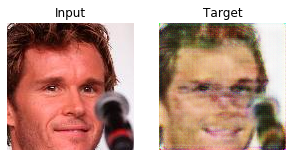

Epoch: 1 / Batch: 0.197% / G Loss: 3.21310 / D Loss: 2.42170 / CLS Loss real: 5.38163 / CLS Loss fake: 0.64909 / Rec Loss: 0.86276191
------------------------------Original Attribute------------------------------
Male
Smiling
Young

------------------------------Target Attribute------------------------------
Brown Hair
Eyeglasses
Male
Smiling
Young


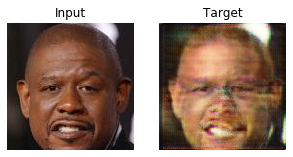

Epoch: 1 / Batch: 0.237% / G Loss: 1.89268 / D Loss: 2.42123 / CLS Loss real: 4.80653 / CLS Loss fake: 0.87659 / Rec Loss: 0.75385147
------------------------------Original Attribute------------------------------
Male

------------------------------Target Attribute------------------------------
Blond Hair
Male
Smiling


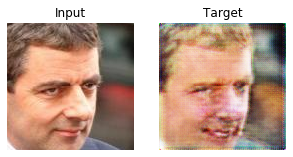

Epoch: 1 / Batch: 0.276% / G Loss: 2.71667 / D Loss: 2.26741 / CLS Loss real: 4.75113 / CLS Loss fake: 0.56802 / Rec Loss: 0.77727342
------------------------------Original Attribute------------------------------
Brown Hair
Heavy Makeup
Smiling

------------------------------Target Attribute------------------------------
Blond Hair
Heavy Makeup


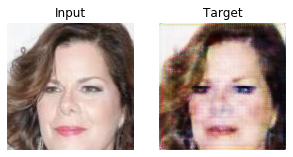

Epoch: 1 / Batch: 0.316% / G Loss: 2.59123 / D Loss: 3.24722 / CLS Loss real: 5.43988 / CLS Loss fake: 0.80890 / Rec Loss: 0.76792306
------------------------------Original Attribute------------------------------
Male

------------------------------Target Attribute------------------------------
Black Hair


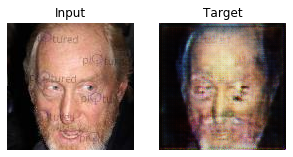

Epoch: 1 / Batch: 0.355% / G Loss: 0.91894 / D Loss: 2.42778 / CLS Loss real: 4.45148 / CLS Loss fake: 0.58875 / Rec Loss: 0.71831316
------------------------------Original Attribute------------------------------
Black Hair
Male
Young

------------------------------Target Attribute------------------------------
Brown Hair
Eyeglasses
Male
Young


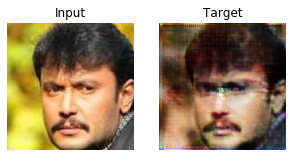

Epoch: 1 / Batch: 0.395% / G Loss: 3.29155 / D Loss: 3.80744 / CLS Loss real: 5.98742 / CLS Loss fake: 1.34541 / Rec Loss: 0.76409143
------------------------------Original Attribute------------------------------
Heavy Makeup
Young

------------------------------Target Attribute------------------------------
Blond Hair
Heavy Makeup
Male
Young


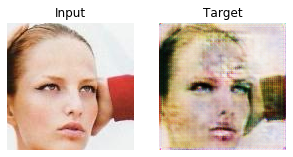

Epoch: 1 / Batch: 0.434% / G Loss: 2.48704 / D Loss: 2.79772 / CLS Loss real: 4.55768 / CLS Loss fake: 0.35843 / Rec Loss: 0.72248578
------------------------------Original Attribute------------------------------
Black Hair
Heavy Makeup
Smiling
Young

------------------------------Target Attribute------------------------------
Blond Hair
Heavy Makeup
Male
Smiling
Young


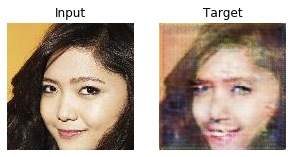

Epoch: 1 / Batch: 0.474% / G Loss: 2.34084 / D Loss: 2.89694 / CLS Loss real: 4.93647 / CLS Loss fake: 0.64393 / Rec Loss: 0.76198417
------------------------------Original Attribute------------------------------
Blond Hair
Heavy Makeup
Smiling
Young

------------------------------Target Attribute------------------------------
Black Hair
Heavy Makeup
Smiling


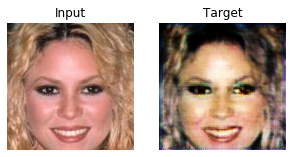

Epoch: 1 / Batch: 0.513% / G Loss: 1.98288 / D Loss: 2.01779 / CLS Loss real: 3.87040 / CLS Loss fake: 0.43579 / Rec Loss: 0.66631681
------------------------------Original Attribute------------------------------
Male

------------------------------Target Attribute------------------------------
Black Hair
Eyeglasses
Male


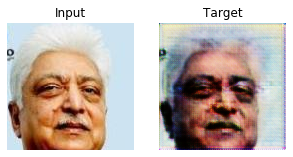

Epoch: 1 / Batch: 0.553% / G Loss: 1.23892 / D Loss: 2.32152 / CLS Loss real: 3.89333 / CLS Loss fake: 0.48709 / Rec Loss: 0.76692706
------------------------------Original Attribute------------------------------
Male
Smiling

------------------------------Target Attribute------------------------------
Blond Hair
Male


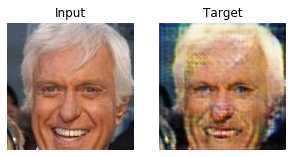

Epoch: 1 / Batch: 0.592% / G Loss: 1.58075 / D Loss: 2.60254 / CLS Loss real: 4.25939 / CLS Loss fake: 0.76591 / Rec Loss: 0.67148137
------------------------------Original Attribute------------------------------
Male
Young

------------------------------Target Attribute------------------------------
Brown Hair
Male


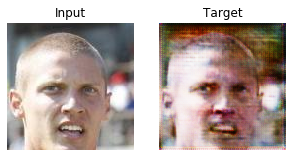

Epoch: 1 / Batch: 0.632% / G Loss: 2.56542 / D Loss: 2.15088 / CLS Loss real: 4.45883 / CLS Loss fake: 0.48820 / Rec Loss: 0.68383521
------------------------------Original Attribute------------------------------
Blond Hair
Young

------------------------------Target Attribute------------------------------
Black Hair
Smiling
Young


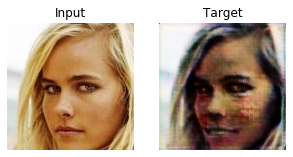

Epoch: 1 / Batch: 0.671% / G Loss: 1.21262 / D Loss: 2.41066 / CLS Loss real: 4.12255 / CLS Loss fake: 0.85950 / Rec Loss: 0.69124347
------------------------------Original Attribute------------------------------
Blond Hair
Heavy Makeup
Smiling

------------------------------Target Attribute------------------------------
Brown Hair
Eyeglasses
Heavy Makeup
Smiling


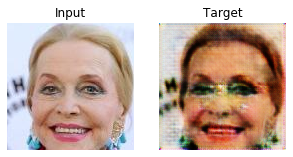

Epoch: 1 / Batch: 0.711% / G Loss: 0.83083 / D Loss: 1.05871 / CLS Loss real: 3.18049 / CLS Loss fake: 0.88083 / Rec Loss: 0.63368899
------------------------------Original Attribute------------------------------
Young

------------------------------Target Attribute------------------------------
Brown Hair
Eyeglasses
Young


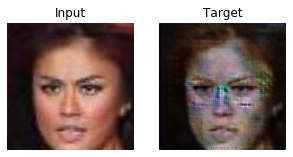

Epoch: 1 / Batch: 0.750% / G Loss: 0.31706 / D Loss: 1.93610 / CLS Loss real: 3.74639 / CLS Loss fake: 0.50407 / Rec Loss: 0.69991517
------------------------------Original Attribute------------------------------
Black Hair
Heavy Makeup
Young

------------------------------Target Attribute------------------------------
Brown Hair
Young


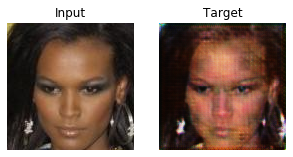

Epoch: 1 / Batch: 0.790% / G Loss: 0.67485 / D Loss: 2.26449 / CLS Loss real: 3.88389 / CLS Loss fake: 0.80846 / Rec Loss: 0.66030765
------------------------------Original Attribute------------------------------
Black Hair
Male
Young

------------------------------Target Attribute------------------------------
Brown Hair
Eyeglasses
Male
Young


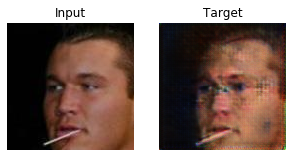

Epoch: 1 / Batch: 0.829% / G Loss: 1.48724 / D Loss: 2.85259 / CLS Loss real: 4.57299 / CLS Loss fake: 0.47071 / Rec Loss: 0.68094659
------------------------------Original Attribute------------------------------
Heavy Makeup
Young

------------------------------Target Attribute------------------------------
Blond Hair
Heavy Makeup
Smiling
Young


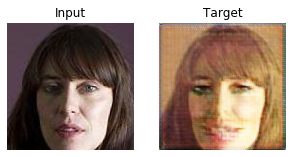

Epoch: 1 / Batch: 0.869% / G Loss: 1.78281 / D Loss: 1.76722 / CLS Loss real: 3.81607 / CLS Loss fake: 0.39381 / Rec Loss: 0.61032122
------------------------------Original Attribute------------------------------
Brown Hair
Heavy Makeup
Smiling
Young

------------------------------Target Attribute------------------------------
Black Hair
Smiling
Young


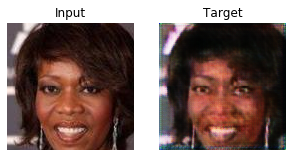

Epoch: 1 / Batch: 0.908% / G Loss: 1.10721 / D Loss: 2.45245 / CLS Loss real: 4.16515 / CLS Loss fake: 0.67060 / Rec Loss: 0.60520989
------------------------------Original Attribute------------------------------
Heavy Makeup
Young

------------------------------Target Attribute------------------------------
Black Hair
Heavy Makeup


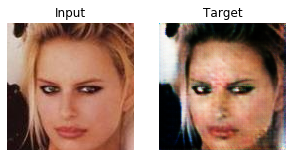

Epoch: 1 / Batch: 0.948% / G Loss: 0.54865 / D Loss: 1.98222 / CLS Loss real: 3.86278 / CLS Loss fake: 0.33095 / Rec Loss: 0.66175801
------------------------------Original Attribute------------------------------
Brown Hair
Heavy Makeup
Smiling
Young

------------------------------Target Attribute------------------------------
Blond Hair
Heavy Makeup
Smiling


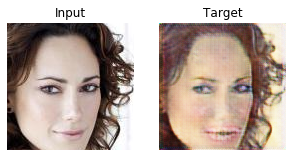

Epoch: 1 / Batch: 0.987% / G Loss: 0.89831 / D Loss: 1.65489 / CLS Loss real: 3.39984 / CLS Loss fake: 0.19613 / Rec Loss: 0.70081836
------------------------------Original Attribute------------------------------
Blond Hair
Heavy Makeup
Smiling

------------------------------Target Attribute------------------------------
Black Hair
Heavy Makeup


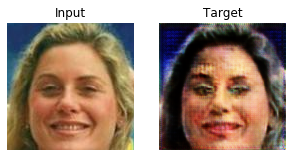

In [16]:
if train_model:
    # Training
    len_data = len(celebA_list)

    count_step = 0 

    for i in range(num_epoch):
        # Shuffle the data 
        np.random.shuffle(celebA_idx_list)

        # Making mini-batch
        for j in range(0, len_data, batch_size): 
            if j + batch_size < len_data:
                data_x_in = np.zeros([batch_size, img_size, img_size, 3])
                attr_origin_ = np.zeros([batch_size, img_size, img_size, attribute_size])
                attr_target_ = np.zeros([batch_size, img_size, img_size, attribute_size])
                
                len_batch_data = 0
                batch_step = 0
                
                # Add batch data without Hat attribute 
                while True:
                    idx_temp = celebA_idx_list[j+batch_step]

                    attribute_temp, is_hat = Get_Attribute(idx_temp)
                    
                    if is_hat == False:
                        img_temp = cv2.imread(celebA_list[idx_temp])
                        data_x_in[len_batch_data,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]
                    
                        attr_origin_[len_batch_data,:,:,:] = attribute_temp

                        target_attr_temp = Get_Target_Attribute(attribute_temp)
                        attr_target_[len_batch_data,:,:,:] = target_attr_temp
                        
                        len_batch_data += 1
                        
                    if len_batch_data == batch_size:
                        break
                        
                    batch_step += 1

            # Run Optimizer!
            _ = sess.run([train_step_cls], feed_dict = {x: data_x_in, 
                                                        attr_origin: attr_origin_, 
                                                        attr_target: attr_target_, 
                                                        is_training: True})
            
            _, loss_d, loss_cls_real = sess.run([train_step_d, d_loss, cls_loss_real], 
                                                feed_dict = {x: data_x_in, 
                                                             attr_origin: attr_origin_, 
                                                             attr_target: attr_target_, 
                                                             is_training: True})

            _, loss_g, loss_cls_fake, loss_rec = sess.run([train_step_g, g_loss, cls_loss_fake, rec_loss], 
                                                           feed_dict = {x: data_x_in, 
                                                                        attr_origin: attr_origin_, 
                                                                        attr_target: attr_target_, 
                                                                        is_training: True})

            print ("Batch: {} / {}".format(j,len_data), end="\r")

            if count_step % show_result_step == 0 and count_step != 0:
                # Print Progess
                print("Epoch: {} / Batch: {:.3f}% / G Loss: {:.5f} / D Loss: {:.5f} / CLS Loss real: {:.5f} / CLS Loss fake: {:.5f} / Rec Loss: {:.8f}".format(
                     (i+1), (j/len_data), loss_g, loss_d, loss_cls_real, loss_cls_fake, loss_rec))

                # Show test images            
                attr_origin_test = np.zeros([1, img_size, img_size, attribute_size])
                attr_target_test = np.zeros([1, img_size, img_size, attribute_size])

                data_x_test = np.zeros([1, img_size, img_size, 3])
                    
                while True:
                    origin_idx = np.random.randint(len(celebA_list))
                    target_idx = np.random.randint(len(celebA_list))

                    attribute_origin_temp, is_hat = Get_Attribute(origin_idx)        

                    if is_hat == False:
                        img_temp = cv2.imread(celebA_list[origin_idx])
                        data_x_test[0,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]

                        attr_origin_test[0,:,:,:] = attribute_origin_temp

                        attribute_target_temp = Get_Target_Attribute(attribute_origin_temp)
                        attr_target_test[0,:,:,:] = attribute_target_temp
                        
                        break

                G_out = sess.run(G, feed_dict = {x: data_x_test, attr_origin: attr_origin_test, 
                                                  attr_target: attr_target_test, is_training: False})

                G_out = (G_out + 1.0)/2

                print("------------------------------Original Attribute------------------------------")
                for k in range(len(attribute_origin_temp[0,0,0,:])):
                    if attribute_origin_temp[0,0,0,k] == 1:
                        print(attr_list_new[k])

                print("\n------------------------------Target Attribute------------------------------")
                for k in range(len(attribute_target_temp[0,0,0,:])):
                    if attribute_target_temp[0,0,0,k] == 1:
                        print(attr_list_new[k])         

                f, ax = plt.subplots(1,2, figsize=(5,5))

                ax[0].imshow(cv2.cvtColor(img_temp[45:45 + img_size, 25: 25+img_size, :], cv2.COLOR_BGR2RGB))
                ax[0].axis('off')
                ax[0].set_title('Input')

                ax[1].imshow(cv2.cvtColor(G_out[0], cv2.COLOR_BGR2RGB))
                ax[1].axis('off')
                ax[1].set_title('Target')

                plt.show()

            count_step += 1

## Image Generation

------------------------------Original Attribute------------------------------
Brown Hair
Male
Young


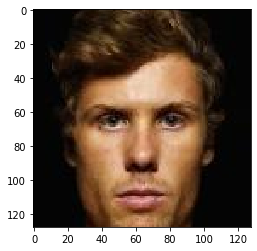

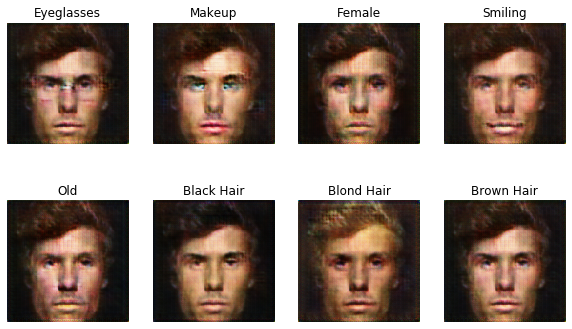

In [29]:
while True:
    origin_idx = np.random.randint(len(celebA_list))
    attribute_origin_temp, is_hat = Get_Attribute(origin_idx)    
    
    if is_hat == False:
        img_temp = cv2.imread(celebA_list[origin_idx])

        data_x_test = np.zeros([1, img_size, img_size, 3])
        data_x_test[0,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]

        attr_origin_test = np.zeros([1, img_size, img_size, attribute_size])
        attr_origin_test[0,:,:,:] = attribute_origin_temp
        
        break
        
plt.imshow(cv2.cvtColor(img_temp[45:45 + img_size, 25: 25+img_size, :], cv2.COLOR_BGR2RGB))

print("------------------------------Original Attribute------------------------------")
for k in range(len(attribute_origin_temp[0,0,0,:])):
    if attribute_origin_temp[0,0,0,k] == 1:
        print(attr_list_new[k])

f2, ax2 = plt.subplots(2,4, figsize=(10,6))
# f2, ax2 = plt.subplots(2,4)

for i in range(len(change_attr_list)):
    change_idx = change_attr_list[i]

    attr_target_test = copy.deepcopy(attr_origin_test)
    
    if attribute_origin_temp[0,0,0,change_idx] == 0:
        attr_target_test[0,:,:,change_idx] = 1
    else:
        attr_target_test[0,:,:,change_idx] = 0
        
    G_out = sess.run(G, feed_dict = {x: data_x_test, attr_origin: attr_origin_test, 
                                  attr_target: attr_target_test, is_training: False})

    G_out = (G_out + 1.0)/2
    
    row = int(i/4)
    col = int(i%4)
    
    ax2[row][col].imshow(cv2.cvtColor(G_out[0], cv2.COLOR_BGR2RGB))
    ax2[row][col].axis('off')
    
    if attr_target_test[0,0,0,change_idx] == 1:
        ax2[row][col].set_title(attr_name[change_idx])
    else:
        ax2[row][col].set_title(no_attr_name[change_idx])

for i, hair_idx in enumerate(hair_attr_list):
    attr_target_test = copy.deepcopy(attr_origin_test)
    
    attr_target_test[0,:,:,hair_idx] = 1
    
    G_out = sess.run(G, feed_dict = {x: data_x_test, attr_origin: attr_origin_test, 
                                  attr_target: attr_target_test, is_training: False})

    G_out = (G_out + 1.0)/2
    
    ax2[1][-3+i].imshow(cv2.cvtColor(G_out[0], cv2.COLOR_BGR2RGB))
    ax2[1][-3+i].axis('off')
    ax2[1][-3+i].set_title(attr_name[hair_idx])    


# Save Model

In [18]:
if train_model:
    os.mkdir(save_path)

    Saver.save(sess, save_path + "/model/model")
    print("Model is saved in {}".format(save_path + "/model/model"))

Model is saved in ./saved_models/20191223-19-18-44_StarGAN_CelebA/model/model
